In [1]:
import polars as pl
import json, os, sys
import logging
from datetime import datetime
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
#from localutils.metricshelper import extract_cwe_for_cve
from functools import lru_cache as LRU

# set up the current date and time as one string
current_date = datetime.now().strftime('%Y-%m-%d')
current_time = datetime.now().strftime('%H:%M:%S')


#Set up logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(f"logs/app-{current_date+current_time}.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [5]:
cve_data = pl.scan_csv('output/cves_epss_kevs_cwe_enriched-2025-03-06.csv')

In [3]:
cve_data.explain()

'Csv SCAN [output/cves_epss_kevs_cwe_enriched-2025-03-06.csv]\nPROJECT */36 COLUMNS'

In [6]:
# plot top 10 CWEs without 'not_found' and 'NVD-CWE-noinfo' values
cve_data['cwe_id'].value_counts().drop(['NVD-CWE-noinfo', 'NVD-CWE-Other']).head(10).plot(kind='pie', autopct='%1.1f%%')
plt.title('Top 10 CWEs for CVEs 2015-2025')

TypeError: LazyFrame is not subscriptable (aside from slicing)

Use `select()` or `filter()` instead.

Text(0.5, 1.0, 'Top 10 CWEs for CVEs 2020-2025')

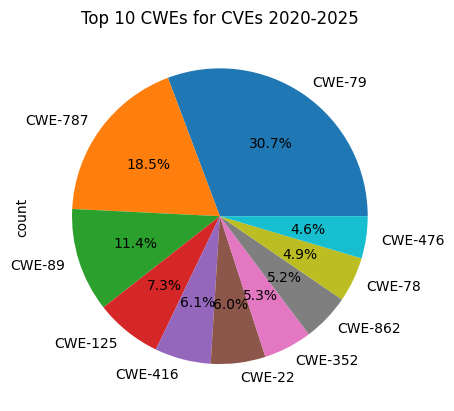

In [7]:
# top 10 CWEs without 'not_found' and 'NVD-CWE-noinfo' values for years 2020-2025
cve_data[cve_data['cve_id'].str.contains('202[0-5]')]['cwe_id'].value_counts().drop(['NVD-CWE-noinfo', 'NVD-CWE-Other']).head(10).plot(kind='pie', autopct='%1.1f%%')
plt.title('Top 10 CWEs for CVEs 2020-2025')


In [8]:
list_of_cwes = list(set(cve_data[~cve_data['cwe_id'].isin(['not_found', 'NVD-CWE-noinfo', 'NVD-CWE-Other'])]["cwe_id"].to_list()))


In [36]:
import requests
url = f"https://cwe-api.mitre.org/api/v1/cwe/weakness/1"
response = requests.get(url)
cwe_data = response.json()

In [37]:
cwe_data

'for weakness: cwe (1) not found, use the category endpoint'

In [9]:
def list_to_csv(lst: list) -> str:
    """Converts a list of strings to a comma-separated string."""
    return ", ".join(str(item).strip() for item in lst if item is not None)

In [10]:
list_to_csv(cwe_data["Weaknesses"][0]["CommonConsequences"][0]["Scope"])

NameError: name 'cwe_data' is not defined

In [11]:
list_to_csv(cwe_data["Weaknesses"][0]["CommonConsequences"][0]["Impact"])

NameError: name 'cwe_data' is not defined

In [12]:
import requests

# add cwe descriptions to cwe_id in cves_cwes_df by matching CWE-ID with the cwes dataframe
from functools import lru_cache
import logging

logger = logging.getLogger(__name__)

@lru_cache(maxsize=128)
def get_cwe_name_and_description(cwe_id):
    url = f"https://cwe-api.mitre.org/api/v1/cwe/weakness/{cwe_id.split('-')[1]}"
    try:
        logger.info(f"Getting CWE data for {cwe_id}")
        response = requests.get(url)
        response.raise_for_status()  # Raise an HTTPError for bad responses
        cwe_data = response.json()
        
        if "Weaknesses" not in cwe_data:
            raise ValueError(f"CWE data for {cwe_id.split('-')[1]} not found")
        
        weakness = cwe_data["Weaknesses"][0]
        cwe_name = weakness.get("Name", "not_found")
        cwe_description = weakness.get("Description", "not_found")
        common_consequences = weakness.get("CommonConsequences", [{}])[0]
        cwe_cc_impact = list_to_csv(common_consequences.get("Impact", ["not_found"]))
        cwe_cc_scope = list_to_csv(common_consequences.get("Scope", ["not_found"]))

        return {
            "cwe_id": cwe_id,
            "cwe_name": cwe_name,
            "cwe_desc": cwe_description,
            "cwe_cc_scope": cwe_cc_scope,
            "cwe_cc_impact": cwe_cc_impact
        }

    except (requests.RequestException, ValueError) as e:
        logger.error(f"Error getting CWE data for {cwe_id}, error: {e}")
        return {
            "cwe_id": cwe_id,
            "cwe_name": "not_found",
            "cwe_desc": "not_found",
            "cwe_cc_scope": "not_found",
            "cwe_cc_impact": "not_found"
        }

def list_to_csv(lst):
    return ', '.join(lst) if lst else "not_found"


cwes_df = pd.DataFrame([get_cwe_name_and_description(cwe_id) for cwe_id in list_of_cwes])

2025-07-16 09:08:06,331 - INFO - Getting CWE data for CWE-451
2025-07-16 09:08:06,935 - INFO - Getting CWE data for CWE-117
2025-07-16 09:08:07,421 - INFO - Getting CWE data for CWE-908
2025-07-16 09:08:07,907 - INFO - Getting CWE data for CWE-502
2025-07-16 09:08:08,508 - INFO - Getting CWE data for CWE-829
2025-07-16 09:08:09,116 - INFO - Getting CWE data for CWE-340
2025-07-16 09:08:09,605 - INFO - Getting CWE data for CWE-219
2025-07-16 09:08:10,093 - INFO - Getting CWE data for CWE-763
2025-07-16 09:08:10,585 - INFO - Getting CWE data for CWE-650
2025-07-16 09:08:11,076 - INFO - Getting CWE data for CWE-425
2025-07-16 09:08:11,566 - INFO - Getting CWE data for CWE-455
2025-07-16 09:08:12,058 - INFO - Getting CWE data for CWE-284
2025-07-16 09:08:12,555 - INFO - Getting CWE data for CWE-79
2025-07-16 09:08:13,285 - INFO - Getting CWE data for CWE-349
2025-07-16 09:08:13,777 - INFO - Getting CWE data for CWE-330
2025-07-16 09:08:14,381 - INFO - Getting CWE data for CWE-670
2025-07-1

AttributeError: 'float' object has no attribute 'split'

In [19]:
cve_data = cve_data.merge(cwes_df, on='cwe_id', how='left')

In [20]:
cve_data = cve_data.fillna("not_found")

In [21]:
cve_data.columns

Index(['cve_id', 'description', 'published_date', 'last_modified_date',
       'cvss_version', 'cwe_id', 'cvss_vector', 'attack_vector',
       'attack_complexity', 'privileges_required', 'user_interaction',
       'base_score', 'base_severity', 'exploitability_score', 'impact_score',
       'scope', 'confidentiality_impact', 'integrity_impact',
       'availability_impact', 'epss', 'percentile', 'cveID', 'vendorProject',
       'product', 'vulnerabilityName', 'dateAdded', 'shortDescription',
       'requiredAction', 'dueDate', 'knownRansomwareCampaignUse', 'notes',
       'cwes', 'Exploitation', 'Automatable', 'Technical Impact', 'cwe_name',
       'cwe_desc', 'cwe_cc_scope', 'cwe_cc_impact'],
      dtype='object')

In [2]:
df = pd.read_csv("output/cves_epss_kevs_cwe_enriched-2025-03-01.csv")

/var/folders/7z/yz2432ws1sn3rvp0tf40s2d00000gp/T/ipykernel_57417/636243177.py:1: DtypeWarning: Columns (4,15,17,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("output/cves_epss_kevs_cwe_enriched-2025-03-01.csv")


In [5]:
cti = pd.read_json("data/download/CTI/enterprise-attack.json")

cti_df = pd.json_normalize(cti["objects"])

In [7]:
df = df.drop_duplicates()

In [ ]:
df